# Pipeline

## Imports

In [209]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import kurtosis, skew, norm, probplot
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost

## Dataset

In [5]:
diamonds = pd.read_csv("https://raw.githubusercontent.com/xtreamsrl/xtream-ai-assignment-engineer/main/datasets/diamonds/diamonds.csv")
diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82
...,...,...,...,...,...,...,...,...,...,...
4995,0.38,Ideal,H,VVS2,62.3,53.3,832,4.65,4.69,2.91
4996,0.33,Premium,G,VVS2,61.3,59.0,927,4.45,4.42,2.72
4997,1.25,Ideal,J,VVS2,62.1,56.0,5980,6.81,6.84,4.24
4998,0.31,Premium,F,VS2,62.9,58.0,802,4.31,4.27,2.70


## PreProcess Pipeline without Isolation Forest

## Bullet Point

1. Categorical Variables Preprocessing (One hot encoder)
2. Numerical Variables Preprocessing (Log transform price and Standardize)
3. Dimensionality Reduction (PCA)

### Utils

### Functions

In [164]:
# Given a dataset, let us distinguish numerical and categorical variables
def feature_type(data):
    categorical = data.select_dtypes(include=['object']).columns.tolist()
    numerical = data.select_dtypes(include=['number']).columns.tolist()
    return categorical,numerical

# Let us understand which variables to remove based on correlation
def correlated_features(data):
    corr_dict = dict(np.abs(data.corr()['price']))
    # Let us remove price
    del corr_dict['price']
    # Now let us keep track of the features to remove starting with the least correlated ones
    delete_col = [k for k, v in corr_dict.items() if v < 0.05]
    # Append price
    delete_col.append('price')
    # Now let us remove variables with analogus values
    for ix, keys in enumerate(list(corr_dict.keys()),1):
        if keys in delete_col:
            continue
        else:
            for keys2 in list(corr_dict.keys())[ix:]:
                if np.abs(corr_dict[keys] - corr_dict[keys2]) < 0.01 :
                    delete_col.append(keys)
                    break
    return delete_col

def remaining_var(data):
    delete = correlated_features(data)
    cat,num = feature_type(data)
    rem_num = [feature for feature in num if feature not in delete]
    rem_cat = [feature for feature in cat if feature not in delete]
    return rem_cat,rem_num

### Classes

In [215]:
# Classes

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        assert isinstance(columns,list)
        self.columns = columns
    def fit(self,X, y = None):
        return self
    def transform(self,X):
        return X.drop(columns = self.columns)
    
class RemoveErrorsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
    def fit(self,X, y = None):
        return self
    def transform(self,X):
        X = X.copy()
        for col in self.columns:
            X = X[X[col]>0]
        return X      
    
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        assert isinstance(columns,list)
        self.columns = columns
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[col] = np.log1p(X[col])
        return X
    
class ModifiedOnehotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
    def fit(self,X,y= None):
        return self
    def transform(self,X):
        X = X.copy()
        X_encod = pd.get_dummies(X, columns= self.columns, drop_first=True)
        return X_encod
    
class ModifiedStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
    def fit(self,X,y= None):
        return self
    def transform(self,X):
        X = X.copy()
        for col in self.columns:
            X[col] = (X[col] - X[col].mean()) / X[col].std()
        return X

class IsolationForestTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.model = IsolationForest()
        pass
    def fit(self,X,y=None):
        self.model.fit(X)
        return self
    def transform(self,X):
        X = X.copy()
        pred = self.model.predict(X)
        X = X[pred == 1]  
        return X

### Pipeline Construction

In [194]:
numeric_transformer = Pipeline(steps = [('Error_remove',RemoveErrorsTransformer(feature_type(diamonds)[1])),
                                        ('Drop Erroneus',DropColumns(correlated_features(diamonds))),
                                        ('log_transform_price', LogTransformer(columns=['price'])),
                                        ('scaler',ModifiedStandardScaler(remaining_var(diamonds)[1]))])
cat_transformer = Pipeline(steps= [('encoder', ModifiedOnehotEncoder(feature_type(diamonds)[0]))])

preprocessor_no_iso = Pipeline(steps=[('preprocess_num',numeric_transformer),
                               ('preprocessor_cat',cat_transformer)])


C:\Users\len\AppData\Local\Temp\ipykernel_2820\2325876125.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_dict = dict(np.abs(data.corr()['price']))


In [195]:
# Fit
preprocessor_no_iso.fit(diamonds)
#Transform
diamonds_preprocessed_no_iso = preprocessor_no_iso.transform(diamonds)

In [196]:
diamonds_preprocessed_no_iso

,carat,table,price,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.653623,-1.082527,0.665617,0.837145,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,1.059622,-0.640000,0.965399,1.185761,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0.867306,0.245053,0.814784,0.938825,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,1.508358,-0.640000,1.270901,1.403646,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0.226255,-0.197474,0.614551,0.415901,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.884901,-1.834821,-1.039766,-0.905933,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4996,-0.991743,0.687579,-0.933763,-1.181921,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4997,0.974148,-0.640000,0.895113,1.025979,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4998,-1.034480,0.245053,-1.075767,-1.210972,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


## PreProcess Pipeline with Isolation Forest

In [216]:
numeric_transformer = Pipeline(steps = [('Error_remove',RemoveErrorsTransformer(feature_type(diamonds)[1])),
                                        ('Drop Erroneus',DropColumns(correlated_features(diamonds))),
                                        ('log_transform_price', LogTransformer(columns=['price'])),
                                        ('scaler',ModifiedStandardScaler(remaining_var(diamonds)[1]))])
cat_transformer = Pipeline(steps= [('encoder', ModifiedOnehotEncoder(feature_type(diamonds)[0]))])

preprocessor_iso = Pipeline(steps=[('preprocess_num',numeric_transformer),
                               ('preprocessor_cat',cat_transformer),
                               ('outlier remove', IsolationForestTransformer())])

C:\Users\len\AppData\Local\Temp\ipykernel_2820\2325876125.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_dict = dict(np.abs(data.corr()['price']))


In [219]:
# Fit
preprocessor_iso.fit(diamonds)
#Transform
diamonds_preprocessed_iso = preprocessor_iso.transform(diamonds)

In [220]:
diamonds_preprocessed_iso

,carat,table,price,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.653623,-1.082527,0.665617,0.837145,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,1.059622,-0.640000,0.965399,1.185761,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0.867306,0.245053,0.814784,0.938825,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,1.508358,-0.640000,1.270901,1.403646,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0.226255,-0.197474,0.614551,0.415901,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.439939,0.687579,0.576247,0.488530,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
4994,-0.179745,-1.082527,0.349933,0.009183,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4996,-0.991743,0.687579,-0.933763,-1.181921,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4998,-1.034480,0.245053,-1.075767,-1.210972,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


## Linear Model Pipeline

### Without Isolation Forest

In [198]:
# Train, Test split
y = diamonds_preprocessed_no_iso['price']
X = diamonds_preprocessed_no_iso.drop(columns=['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [199]:
linear = LinearRegression()
linear.fit(X_train, y_train)
pred = linear.predict(X_test)

In [200]:
print(f'R2 Score: {round(r2_score(y_test, pred), 4)}')
print(f'MAE: {round(mean_absolute_error(y_test, pred), 4)}$')

R2 Score: 0.931
MAE: 0.1287$


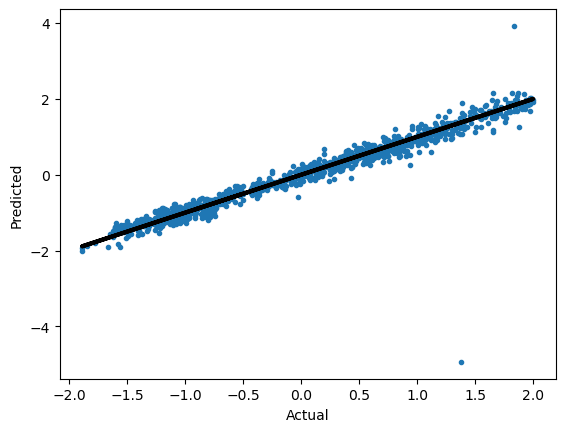

In [203]:
def plot_gof(y_true: pd.Series, y_pred: pd.Series):
  plt.plot(y_true, y_pred, '.')
  plt.plot(y_true, y_true, linewidth=3, c='black')
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.show()

plot_gof(y_test, pred)

### With Isolation Forest

In [221]:
# Train, Test split
y = diamonds_preprocessed_iso['price']
X = diamonds_preprocessed_iso.drop(columns=['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [222]:
linear = LinearRegression()
linear.fit(X_train, y_train)
pred = linear.predict(X_test)

In [223]:
print(f'R2 Score: {round(r2_score(y_test, pred), 4)}')
print(f'MAE: {round(mean_absolute_error(y_test, pred), 4)}$')

R2 Score: 0.9679
MAE: 0.1151$


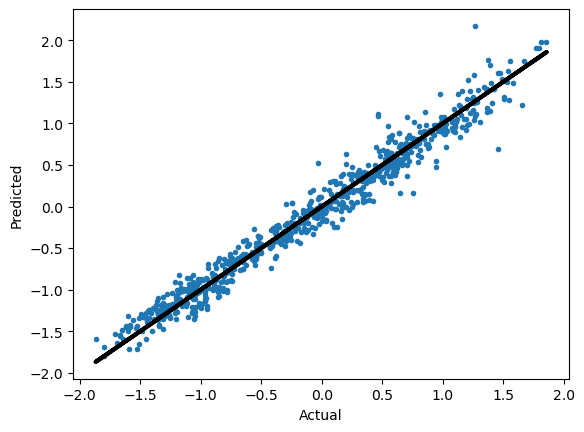

In [224]:
plot_gof(y_test, pred)

## XGBoost Pipeline

### Without Isolation forest

In [201]:
# Data
diamonds_preprocessed_no_iso.head()

,carat,table,price,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.653623,-1.082527,0.665617,0.837145,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,1.059622,-0.640000,0.965399,1.185761,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0.867306,0.245053,0.814784,0.938825,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,1.508358,-0.640000,1.270901,1.403646,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0.226255,-0.197474,0.614551,0.415901,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0


In [230]:
# Train, Test split
y = diamonds_preprocessed_no_iso['price']
X = diamonds_preprocessed_no_iso.drop(columns=['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [231]:
xgb = xgboost.XGBRegressor(enable_categorical=True, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

In [232]:
print(f'R2 Score: {round(r2_score(y_test, xgb_pred), 4)}')
print(f'MAE: {round(mean_absolute_error(y_test, xgb_pred), 4)}$')

R2 Score: 0.9861
MAE: 0.088$


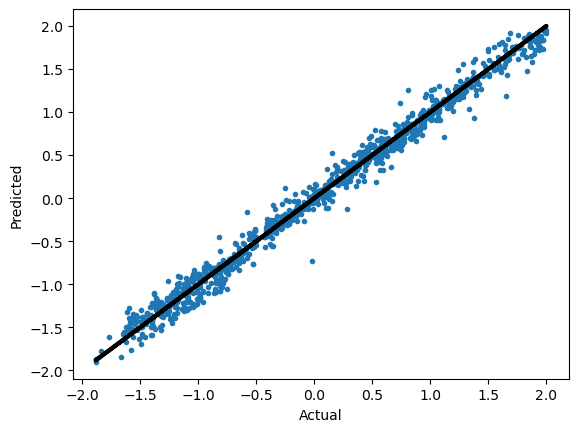

In [233]:
plot_gof(y_test, xgb_pred)

### With Isolation Forest

In [225]:
#Train, Test split
y = diamonds_preprocessed_iso['price']
X = diamonds_preprocessed_iso.drop(columns=['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [226]:
xgb = xgboost.XGBRegressor(enable_categorical=True, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

In [227]:
print(f'R2 Score: {round(r2_score(y_test, xgb_pred), 4)}')
print(f'MAE: {round(mean_absolute_error(y_test, xgb_pred), 4)}$')

R2 Score: 0.9765
MAE: 0.0957$


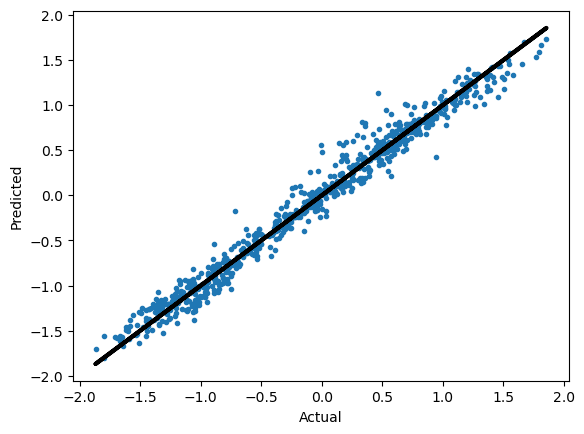

In [228]:
plot_gof(y_test, xgb_pred)

## Ridge Regression Pipeline

In [234]:
# Train, Test split
y = diamonds_preprocessed_no_iso['price']
X = diamonds_preprocessed_no_iso.drop(columns=['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [235]:
ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

In [236]:
print(f'R2 Score: {round(r2_score(y_test, ridge_pred), 4)}')
print(f'MAE: {round(mean_absolute_error(y_test, ridge_pred), 4)}$')

R2 Score: 0.9317
MAE: 0.1285$


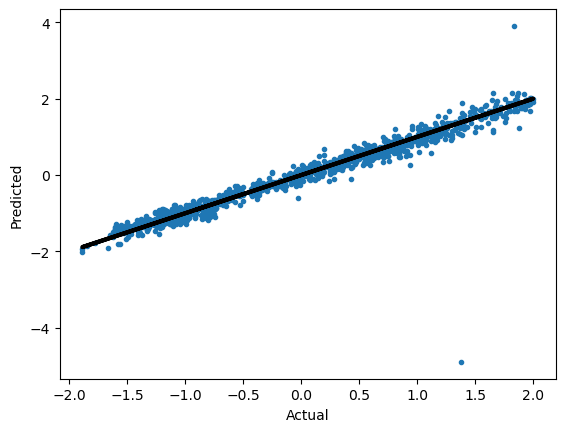

In [238]:
plot_gof(y_test, ridge_pred)

### With Isolation Forest

In [239]:
# Train, Test split
y = diamonds_preprocessed_iso['price']
X = diamonds_preprocessed_iso.drop(columns=['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [240]:
ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

In [241]:
print(f'R2 Score: {round(r2_score(y_test, ridge_pred), 4)}')
print(f'MAE: {round(mean_absolute_error(y_test, ridge_pred), 4)}$')

R2 Score: 0.9679
MAE: 0.1139$


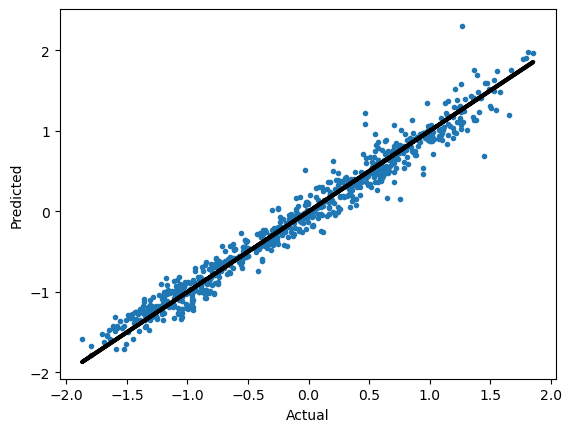

In [242]:
plot_gof(y_test, ridge_pred)